# 🔢 Preparación de datos y entrenamiento del modelo LSTM

En este bloque se realiza el proceso completo de carga, limpieza y transformación de datos de clientes y transacciones, para luego entrenar un modelo LSTM que prediga el monto total mensual de gasto por cliente. Los pasos incluyen:
	•	Carga de datos de clientes y transacciones.
	•	Conversión y validación de fechas.
	•	Cálculo de antigüedad del cliente en meses.
	•	Agregación mensual del monto de transacciones por cliente.
	•	Normalización de variables (monto_total, antiguedad_meses) con MinMaxScaler.
	•	Generación de secuencias temporales (ventanas de tiempo) para alimentar el modelo LSTM.
	•	Definición, compilación y entrenamiento del modelo LSTM.
	•	Evaluación del modelo mediante métricas como MAE, RMSE y R².
	•	Visualización de las predicciones versus los valores reales.

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 2/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 11/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.

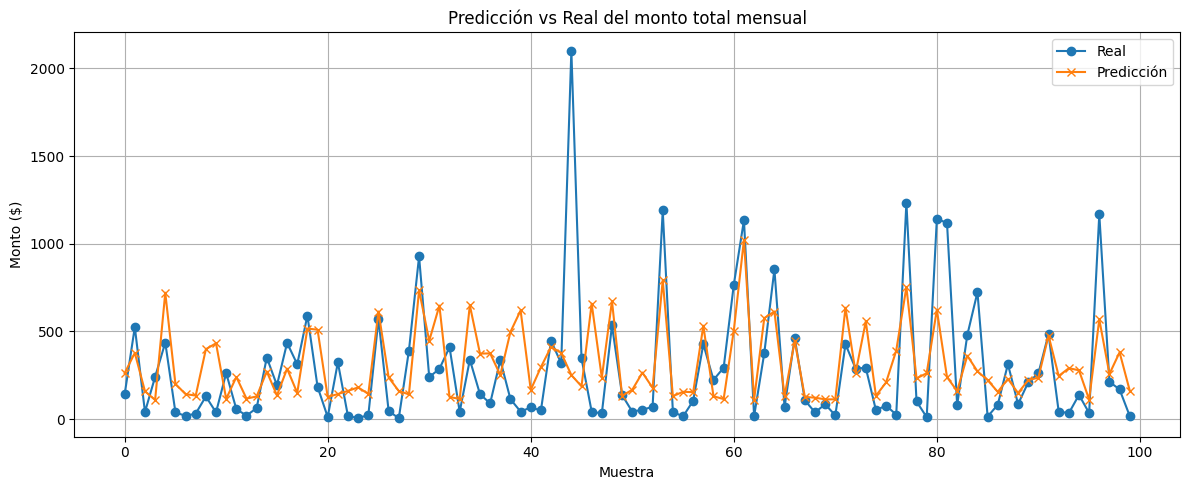

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# === CARGA DE DATOS ===
clientes = pd.read_csv("base_clientes_final(in).csv")
transacciones = pd.read_csv("/content/base_transacciones_final_SINtypeos.csv")

# === CONVERSIÓN DE FECHAS ===
clientes["fecha_alta"] = pd.to_datetime(clientes["fecha_alta"], errors="coerce")
transacciones["fecha"] = pd.to_datetime(transacciones["fecha"], errors="coerce")

# === CÁLCULO DE ANTIGÜEDAD ===
hoy = pd.to_datetime("today")
clientes["antiguedad_meses"] = ((hoy - clientes["fecha_alta"]) / pd.Timedelta(days=30)).astype(int)

# === ELIMINAR TRANSACCIONES SIN FECHA ===
transacciones = transacciones[transacciones["fecha"].notna()].copy()

# === AGRUPACIÓN MENSUAL GENERAL ===
transacciones["mes"] = transacciones["fecha"].dt.to_period("M").apply(lambda r: r.start_time)
gastos_mensuales = transacciones.groupby(["id", "mes"]).agg(
    monto_total=("monto", "sum")
).reset_index()

# === COMBINAR CON DATOS DEL CLIENTE ===
dataset_monto = gastos_mensuales.merge(clientes[["id", "antiguedad_meses"]], on="id", how="left")
dataset_monto = dataset_monto.sort_values(["id", "mes"]).reset_index(drop=True)

# === NORMALIZACIÓN ===
features = ["monto_total", "antiguedad_meses"]
scaler = MinMaxScaler()
dataset_monto[features] = scaler.fit_transform(dataset_monto[features])

# === CONSTRUIR SECUENCIAS ===
n_pasos = 3
X, y = [], []

for _, cliente_data in dataset_monto.groupby("id"):
    cliente_data = cliente_data.sort_values("mes")
    values = cliente_data[["monto_total", "antiguedad_meses"]].values

    for i in range(len(values) - n_pasos):
        X.append(values[i:i+n_pasos])
        y.append(values[i+n_pasos][0])  # monto_total del siguiente mes

X = np.array(X)
y = np.array(y)

# === ENTRENAMIENTO DEL MODELO ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# === EVALUACIÓN ===
y_pred = model.predict(X_test)

# Desnormalizar solo monto_total
plantilla_pred = np.zeros((len(y_pred), len(features)))
plantilla_real = np.zeros((len(y_test), len(features)))
plantilla_pred[:, 0] = y_pred[:, 0]
plantilla_real[:, 0] = y_test

y_pred_desnorm = scaler.inverse_transform(plantilla_pred)[:, 0]
y_test_desnorm = scaler.inverse_transform(plantilla_real)[:, 0]

# === MÉTRICAS ===
mae = mean_absolute_error(y_test_desnorm, y_pred_desnorm)
rmse = np.sqrt(mean_squared_error(y_test_desnorm, y_pred_desnorm))
r2 = r2_score(y_test_desnorm, y_pred_desnorm)

print(f"MAE:  ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²:   {r2:.4f}")

# === GRAFICAR PREDICCIÓN VS REAL ===
plt.figure(figsize=(12, 5))
plt.plot(y_test_desnorm[:100], label="Real", marker='o')
plt.plot(y_pred_desnorm[:100], label="Predicción", marker='x')
plt.title("Predicción vs Real del monto total mensual")
plt.xlabel("Muestra")
plt.ylabel("Monto ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 📈 Función de predicción para un cliente específico

Este bloque define una función personalizada para realizar predicciones del gasto mensual de un cliente dado, usando el modelo LSTM previamente entrenado. La función:
	•	Toma como entrada un cliente_id, el modelo, los datos normalizados, el escalador y los nombres de las variables.
	•	Extrae los últimos n_pasos registros del cliente (por defecto 3 meses).
	•	Genera una predicción normalizada y la desnormaliza usando el escalador original.
	•	Devuelve e imprime el monto estimado que el cliente podría gastar el mes siguiente.

Ideal para hacer predicciones individuales y construir sistemas de recomendación o alertas financieras personalizadas.

In [6]:
def predecir_siguiente_mes(cliente_id, model, dataset_monto, scaler, features, n_pasos=3):
    """
    Predice el siguiente monto_total mensual de un cliente específico.

    Parámetros:
        - cliente_id: str o int, ID del cliente
        - model: modelo LSTM ya entrenado
        - dataset_monto: DataFrame ya normalizado con columnas ["id", "mes", ...features]
        - scaler: MinMaxScaler ya entrenado
        - features: lista de columnas usadas en el modelo
        - n_pasos: número de meses usados como ventana (por defecto 3)

    Retorna:
        - monto_predicho: predicción desnormalizada del siguiente mes
    """
    cliente_data = dataset_monto[dataset_monto["id"] == cliente_id].sort_values("mes")

    if len(cliente_data) < n_pasos:
        print("No hay suficientes meses para hacer la predicción.")
        return None

    valores = cliente_data[features].values[-n_pasos:]  # últimos n_pasos meses
    pred_norm = model.predict(valores[np.newaxis, :, :])[0][0]

    # Desnormalizar usando plantilla
    plantilla = np.zeros((1, len(features)))
    plantilla[0, 0] = pred_norm  # monto_total está en la primera posición
    monto_predicho = scaler.inverse_transform(plantilla)[0][0]

    print(f"Predicción de monto_total para el siguiente mes del cliente {cliente_id}: ${monto_predicho:.2f}")
    return monto_predicho


In [8]:
cliente_id = '003d9abe467a91847d566cf455bd2d7d6c8f7e75'  # usa un ID real de tu dataset
predecir_siguiente_mes(cliente_id, model, dataset_monto, scaler, features, n_pasos=12)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicción de monto_total para el siguiente mes del cliente 003d9abe467a91847d566cf455bd2d7d6c8f7e75: $93.66


np.float64(93.66258367879315)